<a href="https://colab.research.google.com/github/prafful-kumar/Blurred-Image-Recognition/blob/main/Deblurring_U_net(pytorch).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import glob
import os

# torch library
from torch.utils.data import Dataset, DataLoader
import torch 
from torch import nn
from torch.nn import functional as F
from torch import optim
import torchvision
from torchvision import transforms
import torchvision.transforms.functional as TF

In [ ]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# if using cuda
torch.cuda.manual_seed_all(seed)
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False

In [1]:
use_cuda = torch.cuda.is_available()
print('use_cuda: {}'.format(use_cuda))
device = torch.device("cuda" if use_cuda else "cpu")
print("Device to be used : ",device)
!nvidia-smi

NameError: ignored

In [ ]:
!cp -av "/content/drive/MyDrive/Train/Validation.tar.gz" "/content/sample_data"


'/content/drive/MyDrive/Train/Validation.tar.gz' -> '/content/sample_data/Validation.tar.gz'


In [ ]:
!cp -av "/content/drive/MyDrive/Train/train.tar.gz" "/content/sample_data"

'/content/drive/MyDrive/Train/train.tar.gz' -> '/content/sample_data/train.tar.gz'


In [ ]:
!tar --gunzip --extract --verbose --file="/content/sample_data/Validation.tar.gz"
#!tar --gunzip --extract --verbose --file="/content/sample_data/train.tar.gz"


Streaming output truncated to the last 5000 lines.
Validation/sharp/sharp/00112001.png
Validation/sharp/sharp/00112002.png
Validation/sharp/sharp/00112003.png
Validation/sharp/sharp/00112004.png
Validation/sharp/sharp/00112005.png
Validation/sharp/sharp/00112006.png
Validation/sharp/sharp/00112007.png
Validation/sharp/sharp/00112008.png
Validation/sharp/sharp/00112009.png
Validation/sharp/sharp/00112010.png
Validation/sharp/sharp/00112011.png
Validation/sharp/sharp/00112012.png
Validation/sharp/sharp/00112013.png
Validation/sharp/sharp/00112014.png
Validation/sharp/sharp/00112015.png
Validation/sharp/sharp/00112016.png
Validation/sharp/sharp/00112017.png
Validation/sharp/sharp/00112018.png
Validation/sharp/sharp/00112019.png
Validation/sharp/sharp/00112020.png
Validation/sharp/sharp/00112021.png
Validation/sharp/sharp/00112022.png
Validation/sharp/sharp/00112023.png
Validation/sharp/sharp/00112024.png
Validation/sharp/sharp/00112025.png
Validation/sharp/sharp/00112026.png
Validation/sh

In [ ]:
blur_dir = "/content/Validation/blurred/blurred"
sharp_dir = "/content/Validation/sharp/sharp"
blur_list = glob.glob(blur_dir)
sharp_list = glob.glob(sharp_dir)
print("Validation_sharp",len(sharp_list),"\n","Validation_blur",len(blur_list))


Validation_sharp 1 
 Validation_blur 1


In [ ]:
blur_dir = "/content/train/blurred/blurred"
sharp_dir = "/content/train/sharp/sharp"
blur_list = glob.glob(blur_dir)
sharp_list = glob.glob(sharp_dir)
print("Train_sharp",len(sharp_list),"\n","Train_blur",len(blur_list))


Train_sharp 1 
 Train_blur 1


In [ ]:
len(glob.glob("/content/drive/MyDrive/Train/Sharp_1/*"))

18000

In [ ]:
from skimage.io import imread
from torch.utils import data
  
import os
from PIL import Image

class blur_dataset(data.Dataset):
    def __init__(self,img_dir,target_dir,transform=None ):
        self.img_dir = img_dir
        self.target_dir = target_dir
        self.transform = transform
        # self.inputs_dtype = torch.float32
        # self.targets_dtype = torch.float32
        self.images = os.listdir(img_dir) # list all the files in this folder
        self.target_img = os.listdir(target_dir)
        
        
    def __len__(self):
        return len(self.images)

    def __getitem__(self,
                    index: int):
        # Select the sample
        input_ID = self.images[index]
        target_ID = self.target_img[index]
        img_path = os.path.join(self.img_dir, input_ID)
        target_path = os.path.join(self.target_dir,target_ID)
        # Load input and target
        blur, sharp = imread(img_path), imread(target_path)
        #print(input_ID,target_ID)

         # Preprocessing
        if self.transform is not None:
            blur = self.transform(blur)
            sharp = self.transform(sharp)


        # Typecasting
        #blur, sharp = torch.from_numpy(blur).type(self.inputs_dtype), torch.from_numpy(sharp).type(self.targets_dtype)

        return blur, sharp

In [ ]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                ])

training_dataset = blur_dataset(img_dir = blur_dir,
                                       target_dir=sharp_dir,
                                transform=transform)
# testset = blur_dataset(test_dir,
#                        test_target_dir = test_target_dir
#                         download=True,
#                         train=False,
#                         transform=transform)


train_loader = data.DataLoader(dataset=training_dataset,
                                      batch_size=1,
                                      shuffle=True)

#test_dataloader = DataLoader(test_data, batch_size=64, shuffle=False)

x, y = next(iter(train_loader))

print(f'x = shape: {x.shape}; type: {x.dtype}')
print(f'y = shape: {y.shape}; type: {y.dtype}')
print(f'x = min: {x.min()}; max: {x.max()}; mean: {x.mean()}')

x = shape: torch.Size([1, 3, 270, 480]); type: torch.float32
y = shape: torch.Size([1, 3, 270, 480]); type: torch.float32
x = min: -1.0; max: 1.0; mean: 0.09802274405956268


break

In [ ]:
## U-Net Architecture

class conv_block(nn.Module):
    def __init__(self,ch_in,ch_out,batch_norm = False):
        super(conv_block,self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(ch_in, ch_out, kernel_size=3,stride=1,padding=1,bias=False),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch_out, ch_out, kernel_size=3,stride=1,padding=1,bias=False),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True)
        )


    def forward(self,x):
        return self.conv(x)

class U_Net(nn.Module):
    def __init__(self,img_ch,output_ch):
        super(U_Net,self).__init__()
        
        self.Maxpool = nn.MaxPool2d(kernel_size=2,stride=2)

        self.Conv1 = conv_block(ch_in=img_ch,ch_out=64,batch_norm = True)
        self.Conv2 = conv_block(ch_in=64,ch_out=128,batch_norm = True)
        self.Conv3 = conv_block(ch_in=128,ch_out=256,batch_norm = True)
        self.Conv4 = conv_block(ch_in=256,ch_out=512,batch_norm = True)
        self.Conv5 = conv_block(ch_in=512,ch_out=1024,batch_norm = True)

        
        
        self.Up5 = nn.ConvTranspose2d(in_channels=1024,out_channels=512, kernel_size= 2, stride=2)
        self.Up_conv5 = conv_block(ch_in=1024, ch_out=512,batch_norm = True)

        self.Up4 = nn.ConvTranspose2d(in_channels=512,out_channels=256,kernel_size= 2, stride=2)
        self.Up_conv4 = conv_block(ch_in=512, ch_out=256,batch_norm = True)
        
        self.Up3 = nn.ConvTranspose2d(in_channels=256,out_channels=128, kernel_size= 2, stride=2)
        self.Up_conv3 = conv_block(ch_in=256, ch_out=128,batch_norm = True)
        
        self.Up2 = nn.ConvTranspose2d(in_channels=128,out_channels=64,kernel_size= 2, stride=2)
        self.Up_conv2 = conv_block(ch_in=128, ch_out=64,batch_norm = True)

        self.Conv_1x1 = nn.Conv2d(64,out_channels=output_ch,kernel_size=1,stride=1,padding=0)
        #self.sig = nn.Sigmoid()
        #self.act = nn.ReLU()

    def forward(self,x):
        # encoding path
        x1 = self.Conv1(x)

        x2 = self.Maxpool(x1)
        x2 = self.Conv2(x2)
        
        x3 = self.Maxpool(x2)
        x3 = self.Conv3(x3)

        x4 = self.Maxpool(x3)
        x4 = self.Conv4(x4)

        x5 = self.Maxpool(x4)
        x5 = self.Conv5(x5)

        # decoding + concat path
        d5 = self.Up5(x5)

        if x4.shape != d5.shape:
          d5 = TF.resize(d5, size=x4.shape[2:])

        d5 = torch.cat((x4,d5),dim=1)
        d5 = self.Up_conv5(d5)
        
        d4 = self.Up4(d5)
        if x3.shape != d4.shape:
          d4 = TF.resize(d4, size=x3.shape[2:])
        d4 = torch.cat((x3,d4),dim=1)
        d4 = self.Up_conv4(d4)

        d3 = self.Up3(d4)
        if x2.shape != d3.shape:
          d3 = TF.resize(d3, size=x2.shape[2:])
        d3 = torch.cat((x2,d3),dim=1)
        d3 = self.Up_conv3(d3)

        d2 = self.Up2(d3)
        if x1.shape != d2.shape:
          d2 = TF.resize(d2, size=x1.shape[2:])
        d2 = torch.cat((x1,d2),dim=1)
        d2 = self.Up_conv2(d2)

        d1 = self.Conv_1x1(d2)
        # out = self.act(d1)
        # out = self.sig(d1)
        out = torch.tanh(d1)
        return out
 

In [ ]:
class PSNR:
    """Peak Signal to Noise Ratio
    img1 and img2 have range [0, 255]"""

    def __init__(self):
        self.name = "PSNR"

    @staticmethod
    def __call__(img1, img2):
        dc = dice_coef(img1,img2)
        mse = torch.mean((img1 - img2) ** 2) + dc
        return 20 * torch.log10(255.0 / torch.sqrt(mse + 0.0001))



def dice_coef(y_pred,y_true):
    y_true_f = torch.flatten(y_true)
    y_pred_f = torch.flatten(y_pred)
    intersection = torch.sum(y_true_f * y_pred_f)
    return (2.0 * intersection + 1.0) / (torch.sum(y_true_f) + torch.sum(y_pred_f) + 1.0)


def jacard_coef(y_pred,y_true):
    y_true_f = torch.flatten(y_true)
    y_pred_f = torch.flatten(y_pred)
    intersection = torch.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (torch.sum(y_true_f) + torch.sum(y_pred_f) - intersection + 1.0)


def jacard_coef_loss(y_pred,y_true):
    return -jacard_coef(y_true, y_pred)


def dice_coef_loss(y_pred,y_true):
    return -dice_coef(y_true, y_pred)


def save_checkpoint(state, filename="checkpoint_2epoch.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)

def load_checkpoint(checkpoint, model):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
"""if LOAD_MODEL:
        load_checkpoint(torch.load("my_checkpoint.pth.tar"), model)"""

def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)



17000it [26:23, 10.74it/s]
17000it [26:08, 10.84it/s]


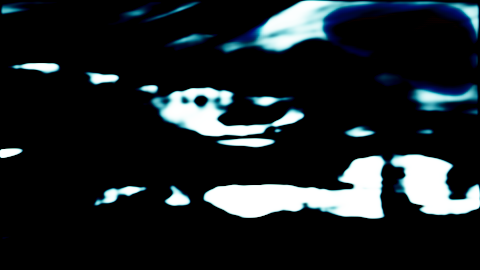

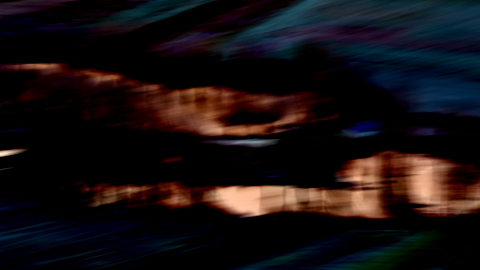

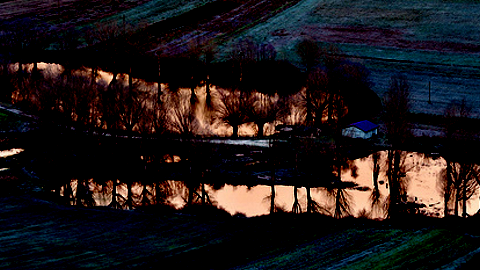

=> Saving checkpoint
---  seconds --- 3153


In [ ]:
# check whether input shape is equal to output shape
import cv2
from google.colab.patches import cv2_imshow
from torch.cuda import amp
def test():
 
  lr=0.0001
  model = U_Net(img_ch=3,output_ch=3).to(device)
  optimizer = optim.Adam(model.parameters(), lr=lr)
  # model.load_state_dict(checkpoint['state_dict'])
  # optimizer.load_state_dict(checkpoint['optimizer'])
  model.apply(init_weights)
  # #model.cuda()
  
  batch_size = 5
  n_epochs = 2
  #blur,sharp = next(iter(train_loader))
  scaler = amp.GradScaler()
  for epoch in range(1, n_epochs+1):
    
      # monitor training loss
      
      ###################
      # train the model #
      ###################
      progress_bar = tqdm(enumerate(train_loader))

      for batch_idx, (blur, sharp) in progress_bar:
          
          ## model.train()
          #model = model.to(device=device,memory_format=torch.channels_last)
        blur = blur.to(device=device)
        #targets = targets.float().unsqueeze(1).to(device=device) # unsqueeze will add dimension for channels
        sharp = sharp.to(device=device) 
        #sharp = sharp.permute(0,3,1,2)
        optimizer.zero_grad()
        #psnr = PSNR()

        
        # forward
        with amp.autocast():
            #predictions = model(blur.permute(0,3,1,2))
            predictions = model(blur)
            loss = jacard_coef_loss(predictions, sharp)
            
            #psnr_loss = -psnr(predictions*255.0, sharp*255.0) 
            
              

        # backward
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        
        #print("Epoch: ",epoch,"loss",loss)
        #DISPLAYING THE LOSS
        # i +=1
        # progress_bar.set_description(
        # "Epoch : {}, Iter: {} Training Loss : {}".format(epoch,i, loss.item()))
      if torch.isnan(loss):
        break
  t = predictions[0]
  t = t.permute(1,2,0)
  t = t.detach().cpu().numpy()*255
  cv2_imshow(t)
  t = blur[0]
  t = t.permute(1,2,0)
  t = t.detach().cpu().numpy()*255
  cv2_imshow(t)
  t = sharp[0]
  t = t.permute(1,2,0)
  t = t.detach().cpu().numpy()*255
  cv2_imshow(t)
  checkpoint_25epoch = {"state_dict": model.state_dict(),"optimizer":optimizer.state_dict()}
  save_checkpoint(checkpoint_25epoch)
  return model,checkpoint_25epoch,blur,sharp,predictions
    
import time

if __name__ == "__main__":
  start_time = time.time()
  model,checkpoint,blur,sharp,predictions = test()
  print("---  seconds ---" , int(((time.time() - start_time))))
    
    



In [ ]:
val_blur_dir = "/content/Validation/blurred/blurred"
val_sharp_dir = "/content/Validation/sharp/sharp"
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                ])

val_dataset = blur_dataset(img_dir = val_blur_dir,
                                       target_dir=val_sharp_dir,
                                transform=transform)

val_loader = data.DataLoader(dataset= val_dataset,
                                      batch_size= 1,
                                      shuffle=False)


def save_predictions_as_imgs(
    val_loader, model, folder="saved_images1/", device="cuda"
):
    model.eval()
    for idx, (x, y) in enumerate(val_loader):
        x = x.to(device=device)
        with torch.no_grad():
            preds = model(x)
            
          
        torchvision.utils.save_image(
            preds, f"{folder}/pred_{idx}.png"
        )
        torchvision.utils.save_image(y, f"{folder}{idx}.png")

    model.train()

# print some examples to a folder
save_predictions_as_imgs(
    val_loader, model, folder="saved_images1/", device=device
)    

Copying checkpoint to drive

In [ ]:
!cp -av "/content/checkpoint_25epoch.pth.tar" "/content/drive/MyDrive/Common"

'/content/checkpoint_25epoch.pth.tar' -> '/content/drive/MyDrive/Common/checkpoint_25epoch.pth.tar'
